In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## 1.Предобработка данных

In [2]:
# Извлечение признаков в DataFrame
features_train = pd.read_csv("./data/features.csv", index_col="match_id")
features_test = pd.read_csv("./data/features_test.csv", index_col="match_id")


# Оценка пропущенных значений
print("Количество образцов с пропущенными значениями в обучающей выборке по признакам:")
print(features_train.isnull().sum().loc[features_train.isnull().sum() > 0])
print(f"Всего образцов в обучающей выборке: {features_train.shape[0]}", "\n")

print("Количество образцов с пропущенными значениями в тестовой выборке по признакам:")
print(features_test.isnull().sum().loc[features_test.isnull().sum() > 0])
print(f"Всего образцов в тестовой выборке: {features_test.shape[0]}", "\n")

Количество образцов с пропущенными значениями в обучающей выборке по признакам:
first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64
Всего образцов в обучающей выборке: 97230 

Количество образцов с пропущенными значениями в тестовой выборке по признакам:
first_blood_time               3552
first_blood_team               3552
first_blood_player1            3552
first_blood_player2            7766
radiant_bottle_time            2895
radiant_courier_time            127
radiant_flying_courier_time    4885
radiant_first_ward_time         330
dire_bottle_time               2842
dire_courier_tim

In [40]:
# Обработка пропусков
features_train.fillna(0, inplace=True)
features_test.fillna(0, inplace=True)

# Разбиение на категориальные и числовые признаки
X_train_categorical = features_train[['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                                      'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
X_train_numeric = features_train.iloc[:, :-6].drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                                      'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1)
Y_train = features_train['radiant_win']

X_test_categorical = features_test[['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                                    'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']]
X_test_numeric = features_test.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                                     'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis=1)

In [75]:
# Обработка числовых признаков

# Обработка выбросов. Для сохранения объема выборки использовано 3 IQR
Q1 = X_train_numeric.quantile(q=0.25)
Q3 = X_train_numeric.quantile(q=0.75)
IQR = X_train_numeric.apply(st.iqr)

X_train_numeric_clean = X_train_numeric[~((X_train_numeric < (Q1 - 3*IQR)) | (X_train_numeric > (Q3 + 3*IQR))).any(axis=1)]
Y_train_clean = Y_train.loc[X_train_numeric_clean.index]

X_test_numeric_clean = X_test_numeric[~((X_test_numeric < (Q1 - 3*IQR)) | (X_test_numeric > (Q3 + 3*IQR))).any(axis=1)]

# Масштабирование признаков
scaler = StandardScaler()

X_train_numeric_std = scaler.fit_transform(X_train_numeric_clean.to_numpy())
X_test_numeric_std = scaler.transform(X_test_numeric_clean.to_numpy())

print(f"Всего образцов в обучающей выборке: {X_train_numeric_std.shape[0]}")
print(f"Всего образцов в тестовой выборке: {X_test_numeric_std.shape[0]}")

Всего образцов в обучающей выборке: 87436
Всего образцов в тестовой выборке: 15443


In [115]:
# Обработка категориальных признаков

X_train_categorical_clean = X_train_categorical.loc[X_train_numeric_clean.index]
X_test_categorical_clean = X_test_categorical.loc[X_test_numeric_clean.index]

# Унитарное кодирование типов игровых комнат
encod = OneHotEncoder()

X_train_lobby_encod = encod.fit_transform(X_train_categorical_clean['lobby_type'].to_numpy().reshape(-1, 1))
X_test_lobby_encod = encod.transform(X_test_categorical_clean['lobby_type'].to_numpy().reshape(-1, 1))

# Преобразование типов героев
def transform_hero(data, N=112):
    """Функция преобразует категориальные признаки, обозначающие типы героев в командах

    Args:
        data (DataFrame): Таблица типов героев у игроков
        N (int): Количество уникальных героев в игре

    Returns:
        X_pick (array): массив (n_samples, N) с закодированными типами героев. 
                        0 - не учавствовал в матче, 1 - был в составе одной команды, (-1) - был в составе другой команды
                        
    """
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(5):
            X_pick[i, data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
            
    return X_pick

X_train_heroes = transform_hero(X_train_categorical_clean.iloc[:, 1:])
X_test_heroes = transform_hero(X_test_categorical_clean.iloc[:, 1:])

In [119]:
# Формирование матриц объекты-признаки

X_train = np.hstack((X_train_numeric_std, X_train_lobby_encod.toarray(), X_train_heroes))
X_test = np.hstack((X_test_numeric_std, X_test_lobby_encod.toarray(), X_test_heroes))

## 2. Обучение моделей

In [136]:
# Подготовка решетчатого поиска

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid_lr = {'C': [10**-2, 10**-1, 1, 10, 100], 'solver': ['lbfgs', 'newton-cholesky']}
param_grid_gb = {'learning_rate': [0.1, 0.05, 0.2, 0.5], 'n_estimators': [10, 20, 30, 50]}

# Инициализация моделей

logreg = LogisticRegression(penalty='l2', max_iter=500)
gbc = GradientBoostingClassifier()

In [137]:
# Логистическая регрессия. Подбор параметров
grid_search_lr = GridSearchCV(logreg, param_grid_lr, scoring='roc_auc', cv=stkfold, verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train, Y_train_clean)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=500), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'newton-cholesky']},
             scoring='roc_auc', verbose=1)

In [143]:
grid_search_lr_df = pd.DataFrame(grid_search_lr.cv_results_)

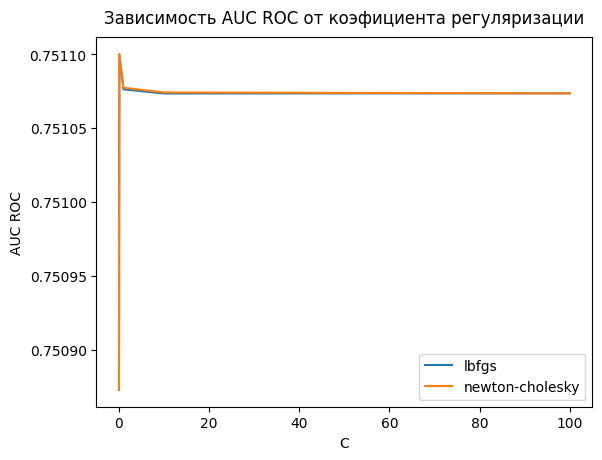

In [171]:
plt.plot(param_grid_lr['C'], 
         grid_search_lr_df['mean_test_score'].loc[grid_search_lr_df['param_solver'] == 'lbfgs'],
         param_grid_lr['C'], 
         grid_search_lr_df['mean_test_score'].loc[grid_search_lr_df['param_solver'] == 'newton-cholesky'])
plt.title('Зависимость AUC ROC от коэфициента регуляризации', pad=10)
plt.xlabel('C')
plt.ylabel('AUC ROC')
plt.legend(['lbfgs', 'newton-cholesky'], loc='lower right')
plt.show()

In [159]:
best_lr_clf = grid_search_lr.best_estimator_
print(f' Лучшие параметры модели {grid_search_lr.best_params_}. AUC ROC при этом {grid_search_lr.best_score_:.4f}')

 Лучшие параметры модели {'C': 0.1, 'solver': 'newton-cholesky'}. AUC ROC при этом 0.7511


In [160]:
# Градиентный бустинг. Подбор параметров

grid_search_gb = GridSearchCV(gbc, param_grid_gb, scoring='roc_auc', cv=stkfold, verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, Y_train_clean)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.2, 0.5],
                         'n_estimators': [10, 20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [173]:
grid_search_gb_df = pd.DataFrame(grid_search_gb.cv_results_)

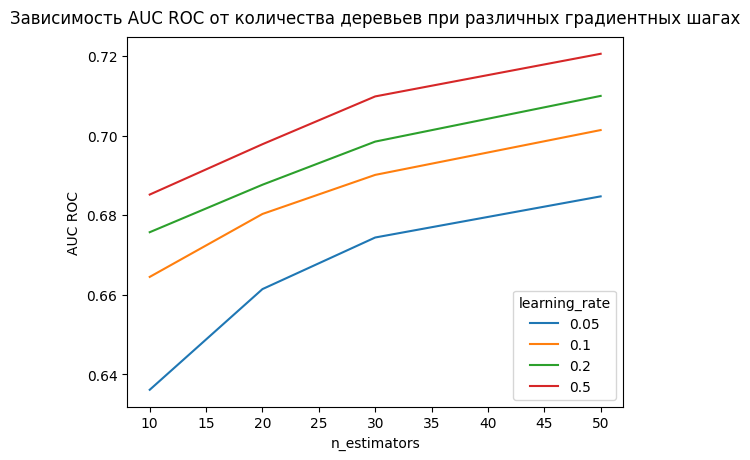

In [169]:
plt.plot(param_grid_gb['n_estimators'], 
         [grid_search_gb_df['mean_test_score'].loc[grid_search_gb_df['param_learning_rate'] == 0.05], 
         grid_search_gb_df['mean_test_score'].loc[grid_search_gb_df['param_learning_rate'] == 0.1],
         grid_search_gb_df['mean_test_score'].loc[grid_search_gb_df['param_learning_rate'] == 0.2],
         grid_search_gb_df['mean_test_score'].loc[grid_search_gb_df['param_learning_rate'] == 0.5]])
plt.title('Зависимость AUC ROC от количества деревьев при различных градиентных шагах', pad=10)
plt.xlabel('n_estimators')
plt.ylabel('AUC ROC')
plt.legend(['0.05', '0.1', '0.2', '0.5'], loc='lower right', title='learning_rate')
plt.show()

In [177]:
print(f' Лучшие параметры модели {grid_search_gb.best_params_}. AUC ROC при этом {grid_search_gb.best_score_:.4f}')

 Лучшие параметры модели {'learning_rate': 0.5, 'n_estimators': 50}. AUC ROC при этом 0.7205


In [ ]:
# Дополнительная оптимизация градиентного бустинга
param_grid_gb_new = {'learning_rate': [0.5, 1, 1.5], 'n_estimators': [70, 100], 'max_depth': [3, 5]}
grid_search_gb_new = GridSearchCV(gbc, param_grid_gb_new, scoring='roc_auc', cv=stkfold, verbose=2, n_jobs=-1)
grid_search_gb_new.fit(X_train, Y_train_clean)

In [178]:
print(f' Лучшие параметры модели {grid_search_gb_new.best_params_}. AUC ROC при этом {grid_search_gb_new.best_score_:.4f}')

 Лучшие параметры модели {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}. AUC ROC при этом 0.7294


In [179]:
# Дополнительная оптимизация не привела к существенному улучшению модели. Параметры оставлены прежними

best_gb_clf = grid_search_gb.best_estimator_

## 3. Предсказание победителя 

In [199]:
pred_lr = best_lr_clf.predict_proba(X_test)[:, 1]
pred_gb = best_gb_clf.predict_proba(X_test)[:, 1]

results = pd.DataFrame({'radiant_win_lr_proba': pred_lr, 'radiant_win_gb_proba': pred_gb}, index=X_test_categorical_clean.index)
results = results.round(2)

# В результирующей таблице указаны вероятности победы команды radiant от двух моделей

results.to_csv('predict_winner.csv', encoding='utf-8')


In [200]:
results

,radiant_win_lr_proba,radiant_win_gb_proba
match_id,,
6,0.82,0.63
10,0.20,0.32
13,0.86,0.85
16,0.25,0.27
19,0.53,0.45
...,...,...
114369,0.71,0.61
114377,0.64,0.53
114378,0.24,0.14
